In [ ]:
%pip install aequitas

In [ ]:
%pip install optuna

In [ ]:
# import libraries
import copy
import glob
import os
import lightgbm as lgbm  # Tested ML method
import numpy as np       # Random number generation
import seaborn as sns    # Plotting library
import pandas as pd      # Read/write data
import yaml              # Read hyperparameter space configuration
import xgboost           # Tested ML method
from aequitas.group import Group                # Fairness metrics
from matplotlib import pyplot as plt            # Plotting method
from sklearn.preprocessing import LabelEncoder  # Categorical encoding for LGBM models
from sklearn import metrics                     # ROC metrics
from sklearn.ensemble import RandomForestClassifier
import joblib

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/ECE697/Project/random_search.py .

In [ ]:
from random_search import RandomValueTrial, suggest_callable_hyperparams  # Random search wrapper methods

In [ ]:
project_dir = "/content/drive/My Drive/Colab Notebooks/ECE697/Project/"

# V2 dataset augmentation



In [ ]:
# Previous 3 synthetic datasets couldn't satisfy expected augmented number of candidates
# Take best performing sample from additional synthetic datasets

synthetic_other_df = pd.read_csv(os.path.join(project_dir, "CTGAN Data/001/synthetic-dataset-001.csv"), index_col=0)

synthetic_other_df = synthetic_other_df.drop(columns=["Unnamed: 0"])

In [ ]:
# read in synthetic data
synthetic_df = pd.read_csv(os.path.join(project_dir, "Synthetic Data/synthetic-dataset-merged.csv"))

# read in dataset to mitigate
variant2_df = pd.read_csv(os.path.join(project_dir, "VariantII.csv"))

In [ ]:
# Checking number of columns in datasets

print(len(list(synthetic_other_df)))
print(len(list(synthetic_df)))
print(len(list(variant2_df)))

32
32
32


In [ ]:
synthetic_df = pd.concat([synthetic_df, synthetic_other_df])

In [ ]:
month_frequency =  variant2_df["month"].value_counts(normalize=True).to_dict()
month_fraud_prev = variant2_df.groupby("month")["fraud_bool"].mean().to_dict()

In [ ]:
print("Percent of total samples from each month:")
month_frequency

Percent of total samples from each month:


{3: 0.150937,
 2: 0.136978,
 0: 0.13244,
 4: 0.127691,
 1: 0.12762,
 5: 0.119324,
 6: 0.108168,
 7: 0.096842}

In [ ]:
print("Frequency of fraud within each month:")
month_fraud_prev

Frequency of fraud within each month:


{0: 0.011325883418906675,
 1: 0.009387243378780755,
 2: 0.008745930003358203,
 3: 0.0092223907988101,
 4: 0.011371200789405674,
 5: 0.011824947202574503,
 6: 0.013405073589231566,
 7: 0.014745668201813262}

In [ ]:
len(synthetic_df[synthetic_df["customer_age"] >= 50])

823725

In [ ]:
print(f"Number of samples younger than 50: { len(variant2_df[variant2_df['customer_age'] < 50]) }\n" \
        f"Number of samples 50 or older: {len(variant2_df[variant2_df['customer_age'] >= 50])}\n" \
        f"Number of samples 50 years old: {len(variant2_df[variant2_df['customer_age'] == 50])}")

Number of samples younger than 50: 494153
Number of samples 50 or older: 505847
Number of samples 50 years old: 382601


In [ ]:
len( variant2_df[(variant2_df["customer_age"] < 50) & (variant2_df["fraud_bool"] == 1)] )

1799

In [ ]:
len( variant2_df[(variant2_df["customer_age"] >= 50) & (variant2_df["fraud_bool"] == 1)] )

9230

In [ ]:
sample_size = 5e5 + 0

expected_positives = {}
expected_negatives = {}

for month in month_fraud_prev.keys():
    expected_positives[month] = round(sample_size * month_frequency[month] * month_fraud_prev[month], ndigits=None)
    expected_negatives[month] = round(sample_size * month_frequency[month] * (1-month_fraud_prev[month]), ndigits=None)

In [ ]:
expected_positives

{0: 750, 1: 599, 2: 599, 3: 696, 4: 726, 5: 706, 6: 725, 7: 714}

In [ ]:
expected_negatives

{0: 65470,
 1: 63211,
 2: 67890,
 3: 74772,
 4: 63120,
 5: 58956,
 6: 53359,
 7: 47707}

In [ ]:
base_dfs = []

SEED = 42

num_months = len(synthetic_df["month"].unique())
seed_possible_values = list(range(500_000))
seed_list = np.random.choice(seed_possible_values, size=num_months, replace=False)

for month, seed in zip(synthetic_df["month"].unique(), seed_list):
    positive_pool = synthetic_df[(synthetic_df["month"]==month) & (synthetic_df["customer_age"] >= 50) & (synthetic_df["fraud_bool"]==1)]
    negative_pool = synthetic_df[(synthetic_df["month"]==month) & (synthetic_df["customer_age"] >= 50) & (synthetic_df["fraud_bool"]==0)]

    positive_sample = positive_pool.sample(expected_positives[month], random_state=seed)
    negative_sample = negative_pool.sample(expected_negatives[month], random_state=seed+SEED)

    base_dfs.extend([positive_sample, negative_sample])

In [ ]:
# Concatenate the filtered samples to obtain the final dataset.
base_df = pd.concat(base_dfs)

In [ ]:
# Now generating the biased samples.
# We will start by defining the protected groups.
synthetic_df["group"] = (synthetic_df["customer_age"] >= 50).map({True:"Minority", False: "Majority"})

In [ ]:
# Helper method to define the joint probability of each combination of
# group and label.

def calculate_probabilities(
    original_prevalence: float,
    prev_ratio: float,
    maj_pct: float,
):
    # Probability notation (p_maj = P(A=maj))
    p_maj = maj_pct
    p_min = 1 - p_maj

    # Calculate prevalence for each class
    prev_min = original_prevalence / (prev_ratio * p_maj + (1 - p_maj))
    prev_maj = prev_ratio * prev_min

    # Calculate joint and conditional probabilities of majority group
    p_maj_and_pos = prev_maj * p_maj
    p_maj_giv_pos: float = p_maj_and_pos / original_prevalence
    p_maj_and_neg = p_maj - p_maj_and_pos
    p_maj_giv_neg: float = p_maj_and_neg / (1 - original_prevalence)

    # Calculate joint and conditional probabilities of minority group
    p_min_and_pos = prev_min * p_min
    p_min_giv_pos: float = p_min_and_pos / original_prevalence
    p_min_and_neg = p_min - p_min_and_pos
    p_min_giv_neg: float = p_min_and_neg / (1 - original_prevalence)

    return p_min_and_pos, p_maj_and_pos, p_min_and_neg, p_maj_and_neg

In [ ]:
# Helper method to obtain a dataframe from given group, month and label.
def get_filtered_df(synthetic_df, group, month, label):
    return synthetic_df[
        (synthetic_df["month"]==month) &
        (synthetic_df["group"]==group) &
        (synthetic_df["fraud_bool"]==label)]


# Method to generate a biased sample controling group size or prevalence (fraud rate)
def group_prevalence_disparity(synthetic_df, original_sample_df, majority_size, fraud_rate_disparity):
    seed_list = np.random.choice(seed_possible_values, size=num_months, replace=False)

    bias_dfs = []

    # Allow for different majority sizes/fraud rates depending on the month of data.
    # This replicates a value if only one is passed.
    if isinstance(majority_size, float):
        majority_size=[majority_size]*original_sample_df["month"].unique().shape[0]
    if isinstance(fraud_rate_disparity, (int, float)):
        fraud_rate_disparity=[fraud_rate_disparity]*original_sample_df["month"].unique().shape[0]

    for month, seed, maj_size, fr_disp in zip(synthetic_df["month"].unique(), seed_list, majority_size, fraud_rate_disparity):
        month_prevalence = original_sample_df[original_sample_df["month"]==month]["fraud_bool"].mean()
        (
            p_min_and_pos,
            p_maj_and_pos,
            p_min_and_neg,
            p_maj_and_neg,
        ) = calculate_probabilities(month_prevalence, 1/fr_disp, maj_size)

        month_size = original_sample_df["month"].value_counts(normalize=True)[month]*sample_size

        # Calculate the needed amount of each combination of group/label to satisfy the disparities in month.
        num_minority_positive = round(month_size*p_min_and_pos, 0)
        num_minority_negative = round(month_size*p_min_and_neg, 0)
        num_majority_positive = round(month_size*p_maj_and_pos, 0)
        num_majority_negative = round(month_size*p_maj_and_neg, 0)

        # Sample the large sample with expected values.
        bias_dfs.extend(
        [
            get_filtered_df(synthetic_df, "Minority", month, 1).sample(int(num_minority_positive), random_state=seed),
            get_filtered_df(synthetic_df, "Minority", month, 0).sample(int(num_minority_negative), random_state=seed+SEED),
            get_filtered_df(synthetic_df, "Majority", month, 1).sample(int(num_majority_positive), random_state=seed+2*SEED),
            get_filtered_df(synthetic_df, "Majority", month, 0).sample(int(num_majority_negative), random_state=seed+3*SEED),
        ]
        )

    return pd.concat(bias_dfs)

In [ ]:
majority_size = 0.5
fraud_rate_disparity = 0.2

augment_df = group_prevalence_disparity(synthetic_df, variant2_df, majority_size, fraud_rate_disparity)

In [ ]:
len(augment_df[augment_df["customer_age"] >= 50])

250001

In [ ]:
len(augment_df[augment_df["customer_age"] < 50])

250000

In [ ]:
len(augment_df[ (augment_df["customer_age"] >= 50) & (augment_df["fraud_bool"] == 1)])

920

In [ ]:
len(augment_df[ (augment_df["customer_age"] < 50) & (augment_df["fraud_bool"] == 1)])

4595

In [ ]:
len(list(augment_df))

33

In [ ]:
# Remember to drop "group" column from augment_df

augment_df = augment_df.drop(columns=["group"])

In [ ]:
len(list(augment_df))

32

In [ ]:
augmented_df = pd.concat([variant2_df, augment_df])
# write merged dataset to csv
augmented_df.to_csv(os.path.join(project_dir, "VariantII_augmented.csv"), index=False, encoding='utf-8')

In [ ]:
len(augmented_df)

1500001

In [ ]:
len(augmented_df[augmented_df["customer_age"] >= 50])

755848

# New experiments with the augmented Type II dataset

In [ ]:
v2_augmented_df = pd.read_csv(os.path.join(project_dir, "VariantII_augmented.csv"))

In [ ]:
len(list(v2_augmented_df))

32

In [ ]:
# Define the label field and categorical columns.
label = "fraud_bool"

categorical_features = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]

In [ ]:
# Create the train and test sets. Shuffle data with `sample` method.
# The split was done by month. The first 6 months as the train, the last 2 months as test.
train_df = v2_augmented_df[v2_augmented_df["month"]<6].sample(frac=1, replace=False)
test_df = v2_augmented_df[v2_augmented_df["month"]>=6].sample(frac=1, replace=False)

In [ ]:
# Encode the categorical variables in the datasets to integers.
# This is expected by LGBM (or columns with the `categorical` data type).

for feat in categorical_features:
    encoder = LabelEncoder()
    encoder.fit(train_df[feat])  # Fit an encoder to the train set.
    train_df[feat] = encoder.transform(train_df[feat])  # Transform train set.
    test_df[feat] = encoder.transform(test_df[feat])    # Transform test set.

In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, metric):
    values = []
    for val in results[metric]:
        values.append(val)
    return values

# LightGBM

In [ ]:
# Load 100 saved LGBM models
lgbm_fnames = []
for name in glob.glob(os.path.join(project_dir, "Models/LGBM/TypeII_*")):
    lgbm_fnames.append(name)

runs = []

# Run on augmented df
for fname in lgbm_fnames:
    model = joblib.load(fname)
    #X_train = train_df.drop(columns=["fraud_bool"])
    #y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM in

In [ ]:
# Graph results of recall vs FPR ratio
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V2/lgbm_plot_results.csv"))

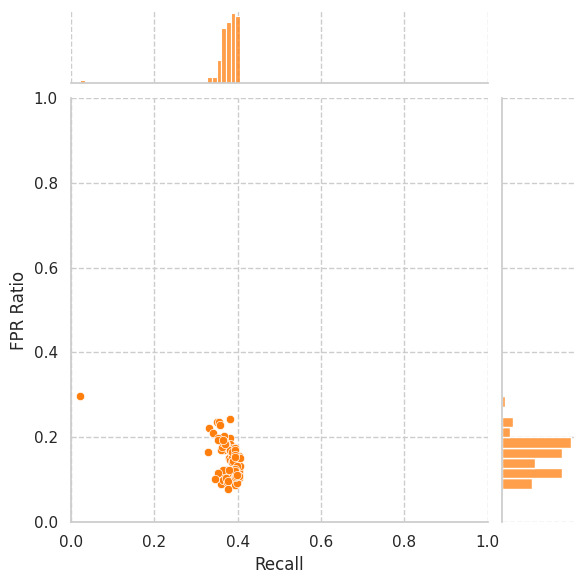

In [ ]:
# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Read saved plot_results.csv for LGBM from original experiment

lgbm_results = pd.read_csv(os.path.join(project_dir, "Models", "LGBM", "plot_results.csv"), index_col=0)

In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets

avg_recall_old = lgbm_results[lgbm_results["Variant"] == "TypeII"]["Recall"].mean()
avg_fpr_ratio_old = lgbm_results[lgbm_results["Variant"] == "TypeII"]["FPR Ratio"].mean()

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

In [ ]:
print(f"Initial V2 dataset had mean recall of {round(avg_recall_old, 3)} and mean FPR ratio of {round(avg_fpr_ratio_old, 3)}\n")
print(f"Augmented V2 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

Initial V2 dataset had mean recall of 0.517 and mean FPR ratio of 0.123

Augmented V2 dataset had mean recall of 0.377 and mean FPR ratio of 0.154


In [ ]:
# Compare average FPR Ratio and Recall model performance between intial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = lgbm_results[lgbm_results['Variant'] == 'TypeII'].sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += lgbm_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += lgbm_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 models of initial V2 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 models of initial V2 dataset had mean recall of 0.553 and mean FPR ratio of 0.122

Top 5 models of augmented V2 dataset had mean recall of 0.404 and mean FPR ratio of 0.127


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = lgbm_results[lgbm_results['Variant'] == 'TypeII'].sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += lgbm_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += lgbm_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 fairness models of initial V2 dataset had mean recall of {round(avg_top_5_recall_old, 3)} " \
        f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")

print(f"Top 5 fairness models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
        f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 fairness models of initial V2 dataset had mean recall of 0.391 and mean FPR ratio of 0.192

Top 5 fairness models of augmented V2 dataset had mean recall of 0.293 and mean FPR ratio of 0.248


### Run 50 new random models to determine if dataset bias mitigation has led to fairer dataset for future experimentation

In [ ]:
# Read .yml for LGBM hyperparameter space
with open("/content/drive/MyDrive/Colab Notebooks/ECE697/Project/lightgbm_hyperparameter_space_original.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
# Run 50 new LGBM models
# 2h

# Define number of trials in Random search.
n_trials=50
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

runs = []

for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparameters.

    model = lgbm.LGBMClassifier(n_jobs=10, **test_hyperparams)

    X_train = train_df.drop(columns=["fraud_bool"])
    y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Fit new model
    model.fit(X_train, y_train, categorical_feature=categorical_features)

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# Graph results of recall vs FPR ratio
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V2/lgbm_plot_results_new.csv"))

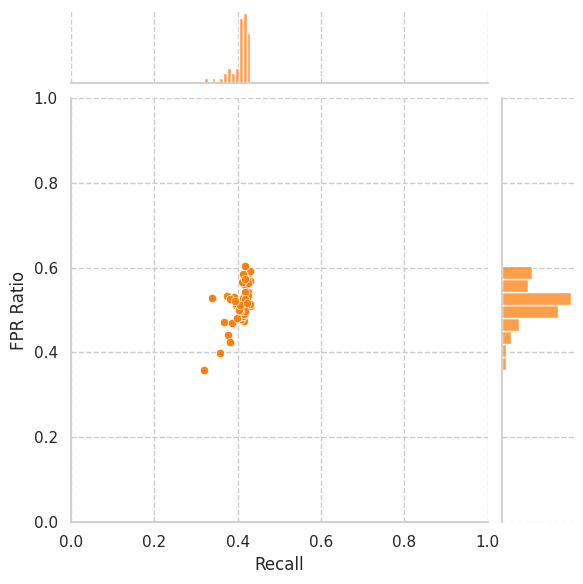

In [ ]:
# Graph results of recall vs FPR ratio
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Find average recall, fpr ratio for newly trained models
top_n = 5
print("\nLGBM:\n\n")

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

print(f"Newly trained LGBM models on augmented V2 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("Recall", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
        f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained fairness models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
           f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


LGBM:


Newly trained LGBM models on augmented V2 dataset had mean recall of 0.405 and mean FPR ratio of 0.518
Top 5 newly trained models of augmented V2 dataset had mean recall of 0.429 and mean FPR ratio of 0.543
Top 5 newly trained fairness models of augmented V2 dataset had mean recall of 0.418 and mean FPR ratio of 0.593


# XGBoost

In [ ]:
# Load 100 saved XGBoost models
xgb_fnames = []
for name in glob.glob(os.path.join(project_dir, "Models/XGB/TypeII_*")):
    xgb_fnames.append(name)

runs = []

# Run on augmented df
for fname in xgb_fnames:
    model = joblib.load(fname)
    #X_train = train_df.drop(columns=["fraud_bool"])
    #y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:57:31] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Graph results of recall vs FPR ratio
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V2/xgb_plot_results.csv"))

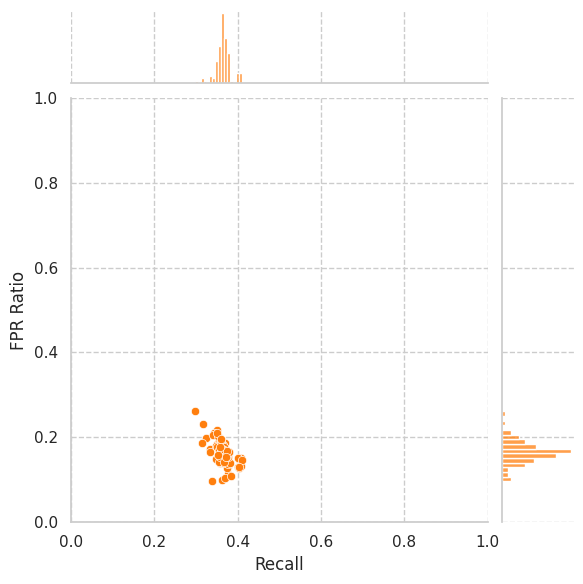

In [ ]:
# Figure out if this can be overlaid on top of below graph

# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Read saved plot_results.csv for XGBoost from original experiment

xgb_results = pd.read_csv(os.path.join(project_dir, "Models", "XGB", "plot_results.csv"), index_col=0)

In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets

avg_recall_old = xgb_results[xgb_results["Variant"] == "TypeII"]["Recall"].mean()
avg_fpr_ratio_old = xgb_results[xgb_results["Variant"] == "TypeII"]["FPR Ratio"].mean()

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

In [ ]:
print(f"Initial V2 dataset had mean recall of {round(avg_recall_old, 3)} and mean FPR ratio of {round(avg_fpr_ratio_old, 3)}\n")
print(f"Augmented V2 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

Initial V2 dataset had mean recall of 0.494 and mean FPR ratio of 0.136

Augmented V2 dataset had mean recall of 0.365 and mean FPR ratio of 0.165


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = xgb_results[xgb_results['Variant'] == 'TypeII'].sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += xgb_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += xgb_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 models of initial V2 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 models of initial V2 dataset had mean recall of 0.547 and mean FPR ratio of 0.125

Top 5 models of augmented V2 dataset had mean recall of 0.406 and mean FPR ratio of 0.142


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = xgb_results[xgb_results['Variant'] == 'TypeII'].sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += xgb_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += xgb_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 fairness models of initial V2 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 fairness models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 fairness models of initial V2 dataset had mean recall of 0.453 and mean FPR ratio of 0.183

Top 5 fairness models of augmented V2 dataset had mean recall of 0.332 and mean FPR ratio of 0.226


### Run 50 new random models to determine if dataset bias mitigation has led to fairer dataset for future experimentation

In [ ]:
# Read .yml for XGB hyperparameter space
with open("/content/drive/MyDrive/Colab Notebooks/ECE697/Project/xgboost_hyperspace_parameter.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
# Run 50 new XGB models
# 18m

# Define number of trials in Random search.
n_trials=50
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

runs = []

for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparameters.

    model = xgboost.XGBClassifier(n_jobs=10, **test_hyperparams, enable_categorical=True)  # enable_categorical=True, # may need to add this

    X_train = train_df.drop(columns=["fraud_bool"])
    y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Fit new model
    model.fit(X_train, y_train)

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

In [ ]:
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V2/xgb_plot_results_new.csv"))

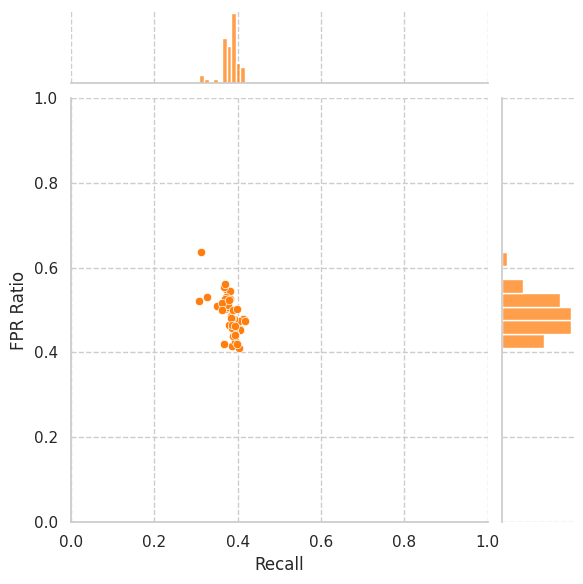

In [ ]:
# Graph results of recall vs FPR ratio

sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Find average recall, fpr ratio for newly trained models
top_n = 5
print("\nXGBoost:\n\n")

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

print(f"Newly trained XGB models on augmented V2 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("Recall", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
        f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained fairness models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
           f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


XGBoost:


Newly trained XGB models on augmented V2 dataset had mean recall of 0.381 and mean FPR ratio of 0.489
Top 5 newly trained models of augmented V2 dataset had mean recall of 0.411 and mean FPR ratio of 0.468
Top 5 newly trained fairness models of augmented V2 dataset had mean recall of 0.361 and mean FPR ratio of 0.569


## Random Forest ##

In [ ]:
# Load 100 saved RF models

rf_fnames = []
for name in glob.glob(os.path.join(project_dir, "Models/RF/TypeII_*")):
    rf_fnames.append(name)

runs = []

# Run on augmented df
for fname in rf_fnames:
    model = joblib.load(fname)
    #X_train = train_df.drop(columns=["fraud_bool"])
    #y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, metric):
    values = []
    for val in results[metric]:
        values.append(val)
    return values

In [ ]:
# Graph results of recall vs FPR ratio
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V2/rf_plot_results.csv"))

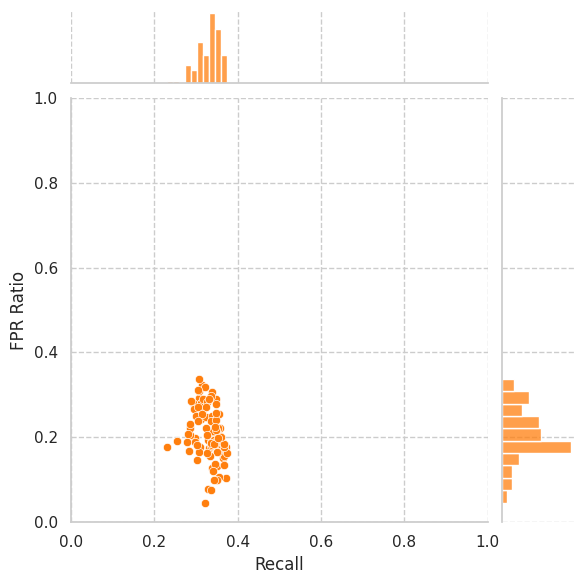

In [ ]:
# Figure out if this can be overlaid on top of below graph

# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Read saved plot_results.csv for Random Forest

rf_results = pd.read_csv(os.path.join(project_dir, "Models", "RF", "plot_results.csv"), index_col=0)

In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets

avg_recall_old = rf_results[rf_results["Variant"] == "TypeII"]["Recall"].mean()
avg_fpr_ratio_old = rf_results[rf_results["Variant"] == "TypeII"]["FPR Ratio"].mean()

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

In [ ]:
print(f"Initial V2 dataset had mean recall of {round(avg_recall_old, 3)} and mean FPR ratio of {round(avg_fpr_ratio_old, 3)}\n")
print(f"Augmented V2 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

Initial V2 dataset had mean recall of 0.462 and mean FPR ratio of 0.144

Augmented V2 dataset had mean recall of 0.33 and mean FPR ratio of 0.207


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = rf_results[rf_results['Variant'] == 'TypeII'].sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += rf_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += rf_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 models of initial V2 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 models of initial V2 dataset had mean recall of 0.507 and mean FPR ratio of 0.111

Top 5 models of augmented V2 dataset had mean recall of 0.371 and mean FPR ratio of 0.158


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = rf_results[rf_results['Variant'] == 'TypeII'].sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += rf_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += rf_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 fairness models of initial V2 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 fairness models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 fairness models of initial V2 dataset had mean recall of 0.442 and mean FPR ratio of 0.213

Top 5 fairness models of augmented V2 dataset had mean recall of 0.311 and mean FPR ratio of 0.32


### Run 50 new random models to determine if dataset bias mitigation has led to fairer dataset for future experimentation

In [ ]:
# Read .yml for RF hyperparameter space

with open("/content/drive/MyDrive/Colab Notebooks/ECE697/Project/randomforest_hyperspace_parameter.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
# Run 50 new RF models
# 38m

# Define number of trials in Random search.
n_trials=50
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

runs = []

for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparameters.

    model = RandomForestClassifier(n_jobs=10, **test_hyperparams)

    X_train = train_df.drop(columns=["fraud_bool"])
    y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Fit new model
    model.fit(X_train, y_train)

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

In [ ]:
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V2/rf_plot_results_new.csv"))

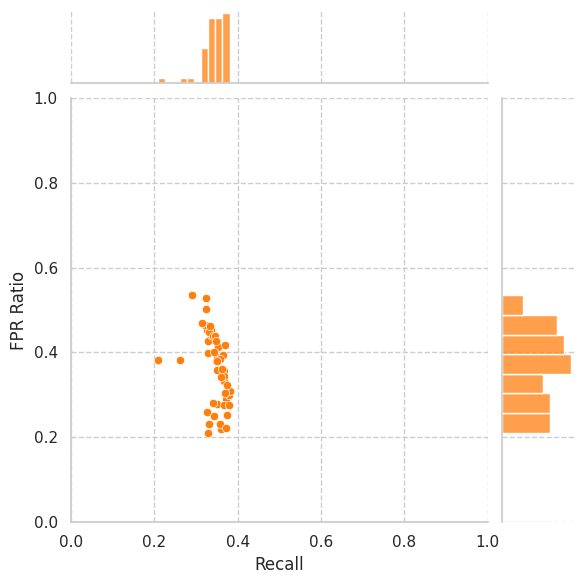

In [ ]:
# Graph results of recall vs FPR ratio

sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Find average recall, fpr ratio for newly trained models
top_n = 5
print("\nRandom Forest:\n\n")

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

print(f"Newly trained RF models on augmented V2 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("Recall", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
        f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained fairness models of augmented V2 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
           f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


Random Forest:


Newly trained XGB models on augmented V2 dataset had mean recall of 0.344 and mean FPR ratio of 0.367
Top 5 newly trained models of augmented V2 dataset had mean recall of 0.378 and mean FPR ratio of 0.292
Top 5 newly trained fairness models of augmented V2 dataset had mean recall of 0.315 and mean FPR ratio of 0.5
